# Data preparation

In [1]:
import pickle
from pathlib import Path
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np



import configuration as config 

## 1. Load combined data

In [3]:
data_df=pd.read_csv(config.COMBINED_DATAFILE)

## 2. Combine origin/destination to 'route'
### 2.1. Data visualization 

In [4]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    LGA         ORF          1338.0      N915XJ         0
1    DTW         MSN           821.0      N907XJ         0
2    MSP         BIS           901.0      N166PQ         0
3    BIS         MSP          1135.0      N166PQ         0
4    MSN         DTW           928.0      N907XJ         0


In [5]:
airport_features=['origin','destination']

print('Unique levels by feature')
data_df[airport_features].nunique()

Unique levels by feature


origin         5885
destination    5915
dtype: int64

In [6]:
print(data_df['origin'].value_counts().head(15))

origin
ATL    29050
ORD    26221
DFW    25948
DEN    25883
CLT    21120
PHX    17444
LAX    16778
LAS    15759
SEA    14375
IAH    13797
MCO    13604
LGA    13009
SFO    12223
BOS    11879
EWR    11804
Name: count, dtype: int64


In [7]:
print(data_df['destination'].value_counts().head(15))

destination
ATL    29041
ORD    26187
DFW    25956
DEN    25850
CLT    21104
PHX    17444
LAX    16785
LAS    15753
SEA    14373
IAH    13796
MCO    13614
LGA    13028
SFO    12229
BOS    11870
EWR    11798
Name: count, dtype: int64


### 2.2. Origin Airport 

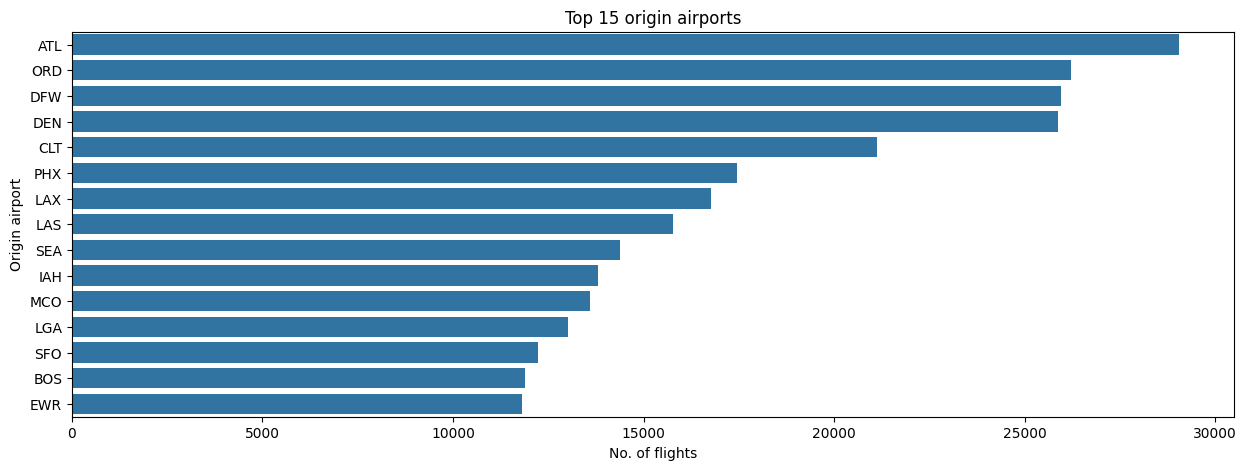

In [8]:
# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['origin'].value_counts().head(15).index
sns.countplot(data=data_df, y='origin', order=level_counts)

plt.title('Top 15 origin airports')
plt.xlabel('No. of flights')
plt.ylabel('Origin airport');
plt.show()

### 2.3. Destination Airport 

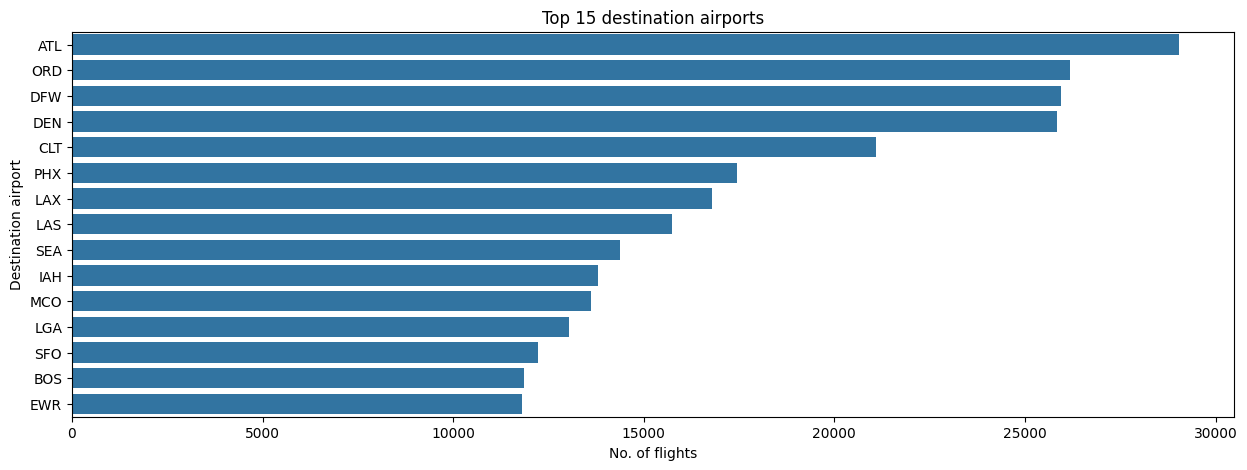

In [9]:
# Plot destination airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['destination'].value_counts().head(15).index
sns.countplot(data=data_df, y='destination', order=level_counts)

plt.title('Top 15 destination airports')
plt.xlabel('No. of flights')
plt.ylabel('Destination airport');
plt.show()

### 2.4. Incident Feature 

In [10]:
data_df['incident'].value_counts()

incident
0    631177
1     14393
Name: count, dtype: int64

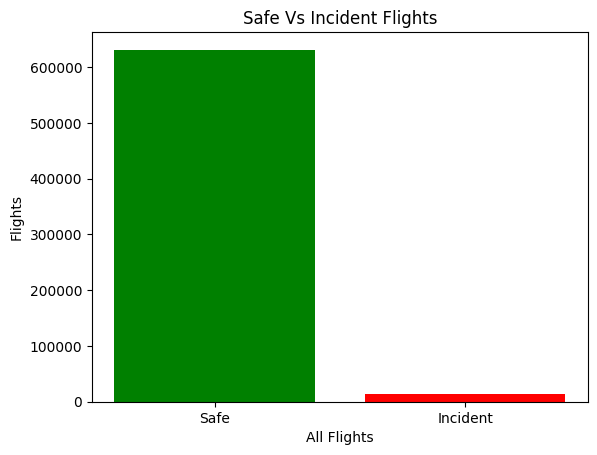

In [11]:
level_counts=data_df['incident'].value_counts()
new_labels = ['Safe', 'Incident']
plt.bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color=('green', 'red'))
plt.title('Safe Vs Incident Flights')
plt.xlabel('All Flights')
plt.xticks(range(len(level_counts)), new_labels)
plt.ylabel('Flights')
plt.show()


In [12]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    LGA         ORF          1338.0      N915XJ         0
1    DTW         MSN           821.0      N907XJ         0
2    MSP         BIS           901.0      N166PQ         0
3    BIS         MSP          1135.0      N166PQ         0
4    MSN         DTW           928.0      N907XJ         0


### 2.5. Route Feature 

In [13]:

data_df['route'] = data_df['origin'] + '_' + data_df['destination']

print(data_df.head())

  origin destination  departure_time tail_number  incident    route
0    LGA         ORF          1338.0      N915XJ         0  LGA_ORF
1    DTW         MSN           821.0      N907XJ         0  DTW_MSN
2    MSP         BIS           901.0      N166PQ         0  MSP_BIS
3    BIS         MSP          1135.0      N166PQ         0  BIS_MSP
4    MSN         DTW           928.0      N907XJ         0  MSN_DTW


## 3. Encode departure time

In [14]:
cyclical_encoded_data_df = data_df.copy()

cyclical_encoded_data_df.head().T

,0,1,2,3,4
origin,LGA,DTW,MSP,BIS,MSN
destination,ORF,MSN,BIS,MSP,DTW
departure_time,1338.0,821.0,901.0,1135.0,928.0
tail_number,N915XJ,N907XJ,N166PQ,N166PQ,N907XJ
incident,0,0,0,0,0
route,LGA_ORF,DTW_MSN,MSP_BIS,BIS_MSP,MSN_DTW


In [15]:
# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    hhmm_int = int(hhmm)
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

# Add minutes since midnight column
cyclical_encoded_data_df['Time'] = cyclical_encoded_data_df['departure_time'].apply(hhmm_to_minutes)

# Add formatted time label for display
cyclical_encoded_data_df['time_label'] = cyclical_encoded_data_df['departure_time'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
cyclical_encoded_data_df['time_sin'] = np.sin(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)  # 1440 minutes in a day
cyclical_encoded_data_df['time_cos'] = np.cos(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(cyclical_encoded_data_df.head(3).round(4).T)


DataFrame with cyclical time encoding:
                      0        1        2
origin              LGA      DTW      MSP
destination         ORF      MSN      BIS
departure_time   1338.0    821.0    901.0
tail_number      N915XJ   N907XJ   N166PQ
incident              0        0        0
route           LGA_ORF  DTW_MSN  MSP_BIS
Time              818.0    501.0    541.0
time_label        13:38    08:21    09:01
time_sin        -0.4147   0.8166    0.704
time_cos          -0.91  -0.5771  -0.7102


### 3.1. Visualization of cyclical encoding 
#### 3.1.1. Sine and cosine vale plot 

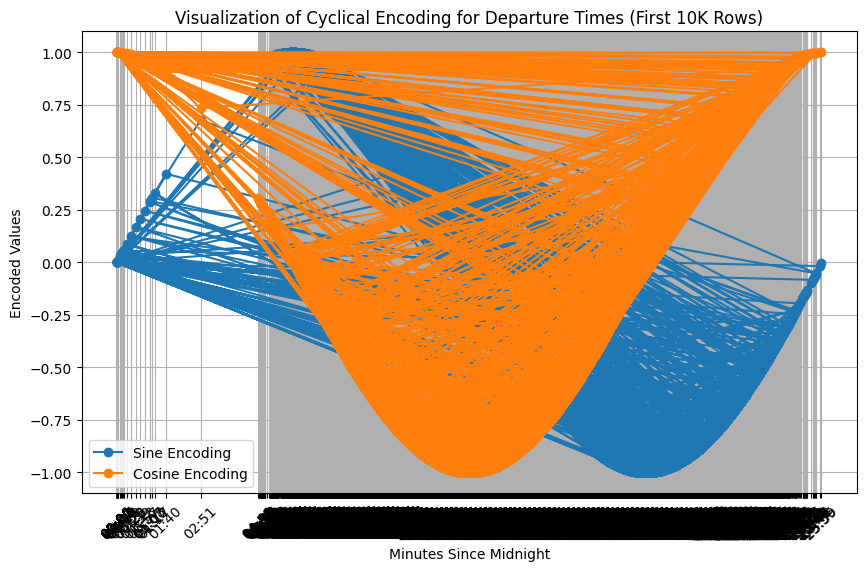

In [16]:
# Filter the DataFrame to only include the first 10K flights
filtered_data = cyclical_encoded_data_df.head(10000)

# Visualization of cyclical encoding
plt.figure(figsize=(10, 6))

# Plot sine and cosine values
plt.plot(filtered_data['Time'], filtered_data['time_sin'], label='Sine Encoding', marker='o')
plt.plot(filtered_data['Time'], filtered_data['time_cos'], label='Cosine Encoding', marker='o')

# Add labels, title, and legend
plt.title("Visualization of Cyclical Encoding for Departure Times (First 10K Rows)")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Encoded Values")
plt.xticks(filtered_data['Time'], filtered_data['time_label'], rotation=45)  # Use time labels
plt.legend()
plt.grid()
plt.show()

#### 3.1.2. Circular Visualization 

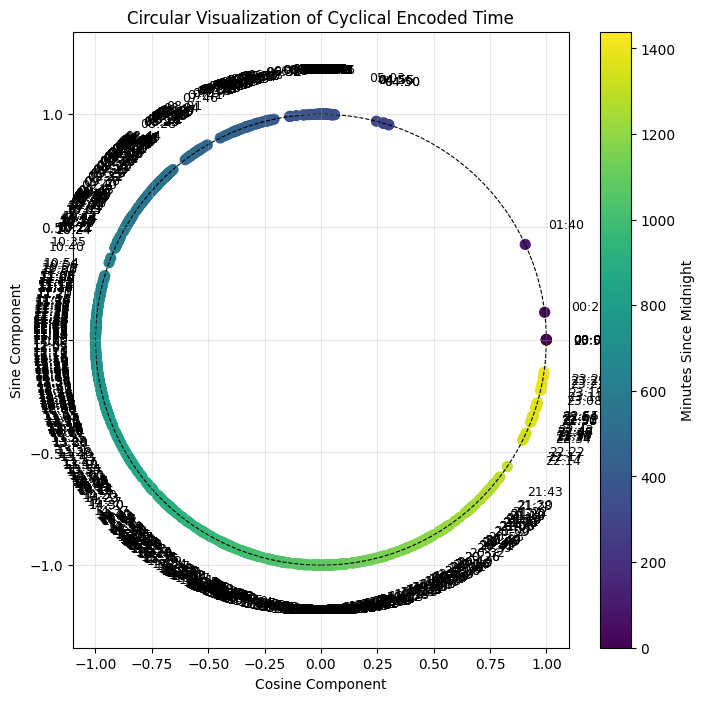

In [17]:
# Filter the DataFrame to only include the first 1000 flights
filtered_data = cyclical_encoded_data_df.head(1000)

# Circular Visualization
plt.figure(figsize=(8, 8))

# Plot the circular points
plt.scatter(filtered_data['time_cos'], filtered_data['time_sin'], c=filtered_data['Time'], cmap='viridis', s=50)

# Add labels for each time point
for i in range(filtered_data.shape[0]):
    plt.text(filtered_data['time_cos'].iloc[i] * 1.2,  # Adjust position slightly outside the circle
             filtered_data['time_sin'].iloc[i] * 1.2,
             filtered_data['time_label'].iloc[i],
             fontsize=9, ha='center', va='center')

# Plot a circle for reference
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=0.8)
plt.gca().add_artist(circle)

# Set aspect ratio and labels
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title("Circular Visualization of Cyclical Encoded Time")
plt.xlabel("Cosine Component")
plt.ylabel("Sine Component")
plt.grid(alpha=0.3)
plt.colorbar(label="Minutes Since Midnight")
plt.show()

## 4. Clean up features

In [18]:
cyclical_encoded_data_df.head(5)

,origin,destination,departure_time,tail_number,incident,route,Time,time_label,time_sin,time_cos
0,LGA,ORF,1338.0,N915XJ,0,LGA_ORF,818.0,13:38,-0.414693,-0.909961
1,DTW,MSN,821.0,N907XJ,0,DTW_MSN,501.0,08:21,0.816642,-0.577145
2,MSP,BIS,901.0,N166PQ,0,MSP_BIS,541.0,09:01,0.704015,-0.710185
3,BIS,MSP,1135.0,N166PQ,0,BIS_MSP,695.0,11:35,0.108867,-0.994056
4,MSN,DTW,928.0,N907XJ,0,MSN_DTW,568.0,09:28,0.615661,-0.788011


In [19]:
cyclical_encoded_data_df.drop(columns=['origin','destination','departure_time','tail_number','Time', 'time_label'], inplace=True)
cyclical_encoded_data_df.head(5)

,incident,route,time_sin,time_cos
0,0,LGA_ORF,-0.414693,-0.909961
1,0,DTW_MSN,0.816642,-0.577145
2,0,MSP_BIS,0.704015,-0.710185
3,0,BIS_MSP,0.108867,-0.994056
4,0,MSN_DTW,0.615661,-0.788011


## 5. Encode Route 

In [20]:
# Frequency encoding for 'route'
route_frequency = cyclical_encoded_data_df['route'].value_counts()
cyclical_encoded_data_df['route_encoded'] = cyclical_encoded_data_df['route'].map(route_frequency)
cyclical_encoded_data_df.drop(columns=['route'], inplace=True)
# Display the updated dataset
print("DataFrame with frequency-encoded features:")
print(cyclical_encoded_data_df.head(5).T)

DataFrame with frequency-encoded features:
                        0           1           2           3           4
incident         0.000000    0.000000    0.000000    0.000000    0.000000
time_sin        -0.414693    0.816642    0.704015    0.108867    0.615661
time_cos        -0.909961   -0.577145   -0.710185   -0.994056   -0.788011
route_encoded  138.000000  110.000000  148.000000  149.000000  110.000000


In [21]:
data_df=cyclical_encoded_data_df.copy()

data_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.414693,0.816642,0.704015,0.108867,0.615661
time_cos,-0.909961,-0.577145,-0.710185,-0.994056,-0.788011
route_encoded,138.000000,110.000000,148.000000,149.000000,110.000000


## 6. Train-Test split

In [33]:
train_df, test_df=train_test_split(
    data_df,
    test_size=0.25, 
    random_state=315
)

In [34]:
train_df.head(5).T

,364865,589809,260269,62911,97461
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.958820,0.996566,-0.884988,0.370557,-0.760406
time_cos,0.284015,-0.082808,-0.465615,-0.928810,0.649448
route_encoded,62.000000,240.000000,154.000000,39.000000,561.000000


In [35]:
train_df.reset_index(drop=True, inplace=True)
train_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.958820,0.996566,-0.884988,0.370557,-0.760406
time_cos,0.284015,-0.082808,-0.465615,-0.928810,0.649448
route_encoded,62.000000,240.000000,154.000000,39.000000,561.000000


In [36]:
test_df.reset_index(drop=True, inplace=True)
test_df.head(5).T

,0,1,2,3,4
incident,1.000000,0.000000,0.000000,0.000000,0.000000
time_sin,0.766044,-0.998630,0.533615,0.258819,0.074108
time_cos,0.642788,0.052336,-0.845728,-0.965926,-0.997250
route_encoded,1.000000,93.000000,575.000000,249.000000,151.000000


## 7. Save

In [37]:
Path(config.PROCESSED_DATA_DIRECTORY).mkdir(exist_ok=True)

data_df.to_csv(config.ENCODED_DATAFILE)

train_df.to_csv(config.TRAINING_DATAFILE)
test_df.to_csv(config.TESTING_DATAFILE)